# Modelo *RMFT* ($\sigma^4$-$\omega$-$\boldsymbol{\rho}$)

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.interpolate import CubicSpline

import scripts.IsospinEoS as isoEoS
import scripts.ResolverTOV as tov

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

Luego de incorporar la autointeracción del campo escalar $\sigma$, agregamos al lagrangiano del modelo el triplete vectorial de isospin $\mathbf{\rho}$, cuya forma es, en unidades naturales $c=\hbar=1$,
$$\mathcal{L}_\rho = -\frac{1}{4}\boldsymbol{\rho}_{\mu\nu}\boldsymbol{\rho}^{\mu\nu} + \frac{1}{2}m_\rho^2\boldsymbol{\rho}_\mu\boldsymbol{\rho}^\mu - \frac{1}{2} g_\rho \bar\psi\gamma^\mu \boldsymbol{\tau} \cdot \boldsymbol{\rho}_\mu \psi,$$

donde hemos tomado únicamente el acople entre la corriente de isospin de los nucleones y el campo isovectorial $\boldsymbol{\rho}$, y hemos omitido el acople de la corriente de isospin del mismo campo, pues estos términos se hacen cero al aplicar la aproximación de campo medio, donde la única componente diferente de cero es la componente temporal del campo neutral $\rho_3^0$.

Ahora, podemos escribir las ecuaciones de autoconsistencia, energía y presión empleando las variables y parámetros adimensionales $\tilde x_{\sigma} = 1-g_{\sigma}\sigma/m, \quad \tilde n = n/m^3, \quad x_i = p_i/m \; (i = n,\,p),\quad \tilde A_{i} = (g_i/m_i)^2m^2, \quad t = (n_p - n_n)/n\,$; y la constante $\lambda = m^4$ con unidades de densidad de energía $\text{MeV/fm}^3$ o equivalentemente $\text{fm}^{-4}$

$$ (1-\tilde x_{\sigma}) - \tilde A_{\sigma}\left[\frac{1}{\pi^2} \left(\int_0^{x_{nF}(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} + \int_0^{x_{pF}(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} \right) - b (1-\tilde x_{\sigma})^2 - c (1-\tilde x_{\sigma})^3\right] = 0$$

\begin{aligned}
\tilde\rho = \frac{\lambda}{2\rho_0} \Bigg[ & (1-\tilde x_{\sigma})^2\left(\tilde A_{\sigma}^{-1} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) \\
& + \left(\tilde A_{\omega}^2 + \frac{1}{4} \tilde A_{\rho} t^2\right) \tilde n^2 + \frac{2}{\pi^2} \left(\int_0^{x_{nF}(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx + \int_0^{x_{pF}(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx\right) \Bigg]
\end{aligned}

\begin{aligned}
\tilde P = \frac{\lambda}{2\rho_0} \Bigg[ & -(1-\tilde x_{\sigma})^2\left(\tilde A_{\sigma}^{-1} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) \\
& + \left(\tilde A_{\omega}^2 + \frac{1}{4} \tilde A_{\rho} t^2\right) \tilde n^2 + \frac{2}{\pi^2} \left(\int_0^{x_{nF}(n)} \frac{x^4 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} + \int_0^{x_{pF}(n)} \frac{x^4 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}}\right) \Bigg]
\end{aligned}

### Ecuación de estado numérica

In [11]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
proton_mass = 1.6726219e-27 # kg
neutron_mass = 1.6749275e-27 # kg
m_nuc_MKS = (proton_mass + neutron_mass)/2.0 # kg
e_MKS = 1.602186021766e-19 # C

# Algunas converciones útiles (multiplicar al primero para obtener el segundo)
Kg_to_fm11 = c_MKS/hbar_MKS*1e-15 # kg to fm^-1
MeV_to_fm11 = e_MKS/(hbar_MKS*c_MKS*1e9) # MeV to fm^-1
MeVfm_to_Jm  = 1e51*e_MKS # MeV/fm to J/m

# Definimos las constantes necesarias en unidades naturales
m_nuc = m_nuc_MKS * Kg_to_fm11 # fm^-1
lambda_ = m_nuc**4 # Constante de escala empleada
rho_0_lambda = lambda_/2 # Escala de energía y presión empleada

# Damos valores a las constantes (Glendenning K=250 m*=0.7) (constantes tilde cuadradas)
A_sigma = 12.230*m_nuc**2 # Walecka: 266.9, 357.4
A_omega =  7.148*m_nuc**2 # Walecka: 195.7, 273.8
A_rho   =  4.410*m_nuc**2 # Nuevo parámetro para el campo rho
b       =  4.312e-3
c       = -4.103e-3
t       = -0.0           # Parámetro de asimetría de isospin (prot-neut, t=0 simétrica, t=+-1 asimétrica)

params = [A_sigma, A_omega, A_rho, b, c, t]

# Calculamos si no hay archivo de la EoS, si no, lo leemos
operacion = 'calc' # 'calc' o 'leer'

if operacion == 'calc':
    # Definimos el rango de densidades para la interpolación de la EoS
    densidad_masa_max = 1e18*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    densidad_masa_min = 1e10*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    n_barions = np.logspace(np.log10(densidad_masa_min), np.log10(densidad_masa_max), 200)
    # Calculamos la EoS
    rho_P, presiones, energias, n_sirve, presion_cambio = isoEoS.EoS(n_barions, params)
    df = pd.DataFrame({'n': n_sirve[presion_cambio:], 'P': presiones[presion_cambio:], 'E': energias[presion_cambio:]})
    df.to_csv('EoS_tables/SigmaOmegaRho_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
elif operacion == 'leer':
    # Leemos los resultados de la EoS
    df = pd.read_csv('EoS_tables/SigmaOmegaRho_rho0_lambda_A_propios.csv')
    n_sirve = df['n'].values
    presiones = df['P'].values
    energias = df['E'].values
    rho_P = CubicSpline(presiones, energias)
    presion_cambio = False

## Solución de las Ecuaciones Hidrostáticas

In [ ]:
# Si la variable presion_cambio no es false, redefinimos los arrays
if presion_cambio:
    # Definimos la densidad de bariones y la presión para la integración del sistema
    n_sirve = n_sirve[presion_cambio:]
    presiones = presiones[presion_cambio:]
    energias = energias[presion_cambio:]
    rho_P = CubicSpline(presiones, energias)

# Definimos la ecuacion de estado para la integración del sistema
print("Primer densidad de barinoes util", "{:2.2e}".format(n_sirve[0]), "1/fm^3 por ende densidad de masa", format(n_sirve[0]*1e45*m_nuc_MKS*1e-3,"2.2e"), "g/cm^3 y presión", format(presiones[0], "2.2e"), "adimensional")
densidad_limite = energias[0] # Densidad de energia límite adimensional para rho_0 = lambda/2
P_rho = CubicSpline(energias, presiones) # Presión en función de la densidad de energía para rho_0 = lambda/2
P_central = P_rho(1) # Presión central en unidades adimensionales para rho_0 = lambda/2

# Definimos los parametros de integración
rf = 20 # Radio final adimensional
dr = 1e-3 # Paso de integración adimensional

# Resolvemos el sistema TOV
rho_nat_to_MKS = 1.0 / MeV_to_fm11 * MeVfm_to_Jm
sol_final = tov.integrador(rf, dr, rho_0_lambda*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)
# Orden: r, m, rho, P, phi
print("Radio final = ", sol_final[0]/1e3, "km, Masa final = ", sol_final[1]/1.989e30, "M_sun")
# tov.graficar_solucion(rf, dr, rho_0_lambda, rho_P, P_central, densidad_limite=densidad_limite)

Primer densidad de barinoes util 1.09e-01 1/fm^3 por ende densidad de masa 1.83e+14 g/cm^3 y presión 2.20e-08 adimensional
Radio final =  10.791070621395043 km, Masa final =  2.1499946938720473 M_sun


Masa máxima: 2.984 M_sun para rho0_m = 1.050e+15 g/cm^3


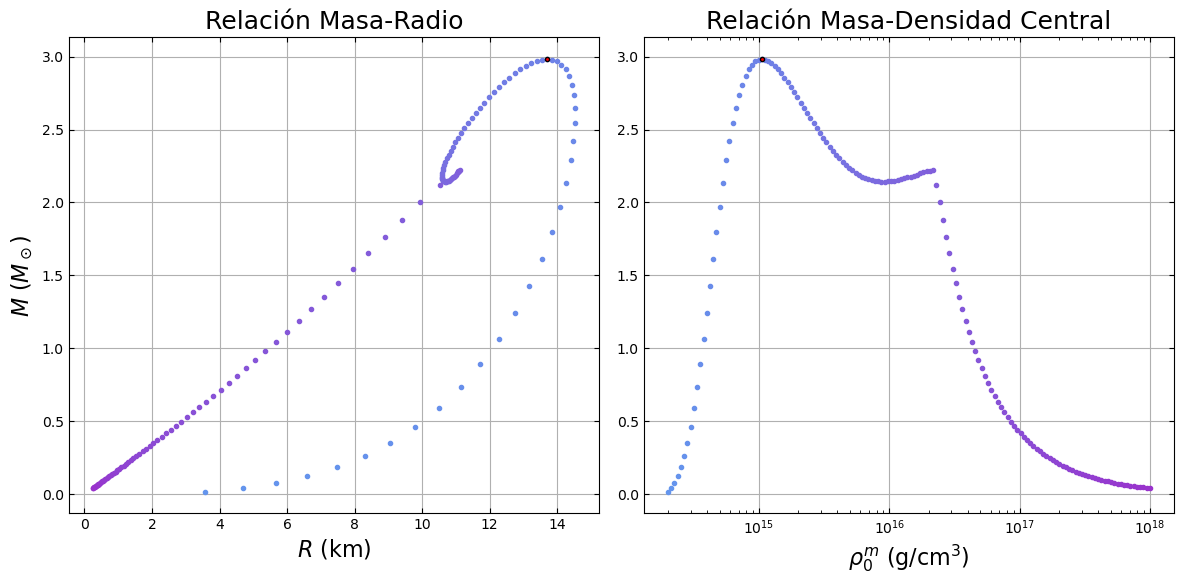

In [ ]:
# Definimos el espacio de densidades centrales de masa para la integración
rhos_masa = np.logspace(np.log10(n_sirve[1]*1e45*m_nuc_MKS*1e-3), 18, 150) # Densidades de masa en kg/m^3 (desde donde es util la EoS)
# rhos_masa = np.logspace(14, 18, 100) # Densidades de masa en kg/m^3

# Calculamos la densidad de energía asociada a cada densidad de masa
rhos = []
for rho_m in rhos_masa:
    densidad_energia, _ = isoEoS.energia_presion(rho_m*1e3/m_nuc_MKS*1e-45, params)
    rhos.append(densidad_energia)
    
# Definimos arrays para la masa y el radio
masas = np.zeros(len(rhos))
radios = np.zeros(len(rhos))

# Resolvemos el sistema TOV para cada densidad central de masa
arg_max = 0
for i in range(len(rhos)):
    rho0 = rhos[i] # Densidad de energía central adimensionalizada con rho_0_lambda
    R = 1.0/rho0 # Factor de conversión para la interpolación adimensionalizada con rho0
    rho_P_prima = lambda P: R*rho_P(P/R) # Interpolación adimensionalizada con rho0 (en función de P adimensional con rho0)
    P_central_prima = R*P_rho(1/R) # Presión central adimensionalizada con rho0
    densidad_limite_prima = R*densidad_limite # Densidad de energía límite adimensionalizada con rho0
    sol_final = tov.integrador(rf, dr, rho0*rho_0_lambda*rho_nat_to_MKS, rho_P_prima, P_central_prima, densidad_limite=densidad_limite_prima)
    radios[i] = sol_final[0] # Radio final en metros
    masas[i] = sol_final[1] # Masa final en kg
    if masas[i] > masas[arg_max]:
        arg_max = i
    # print("Se pudo para densidad de masa =", format(rho_m,"2.2e"), "g/cm^3")
    
# Guardamos los resultados en un archivo MasaRadio_SigmaOmegaRho_rho0_lambda_A_propios.csv
m_sun = 1.989e30 # kg
df = pd.DataFrame({'Masa': masas/m_sun, 'Radio': radios*1e-3, 'rho_m': rhos_masa})
df.to_csv('results/MasaRadio_SigmaOmegaRho_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
    
# Graficamos la relación masa-radio
tov.grafica_masa_radio(radios, masas, rhos_masa)

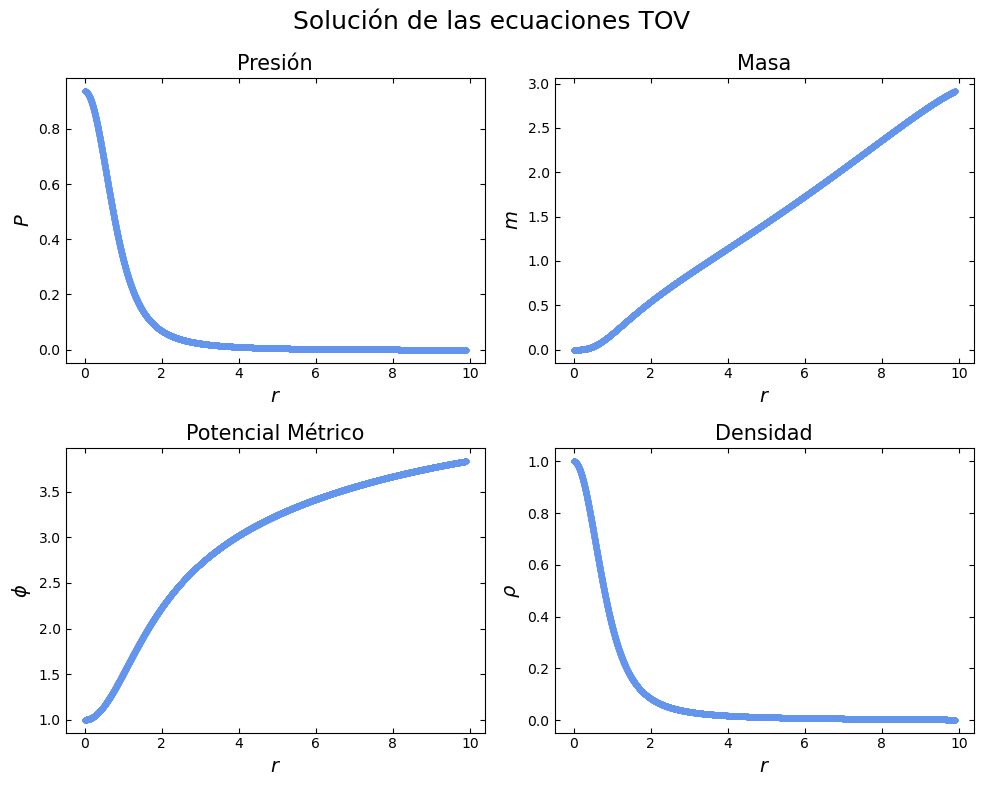

In [ ]:
tov.graficar_solucion(rf, dr, rho_0_lambda*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)

## Resultados de la EoS

### Ecuación de autoconsistencia

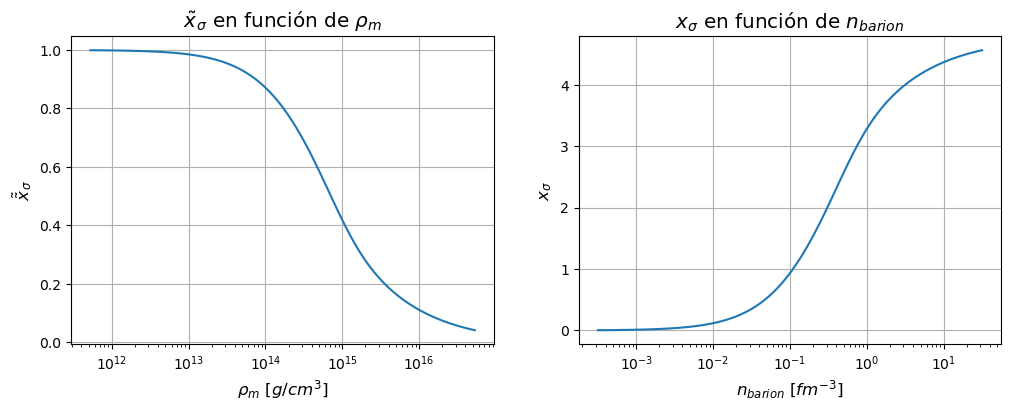

In [12]:
# Testeamos la solucion_x_sigma
n_prove = np.logspace(-3.5, 1.5, 100) 
isoEoS.plot_autoconsistencia(n_prove, params)

### Interpolación y ecuación de estado

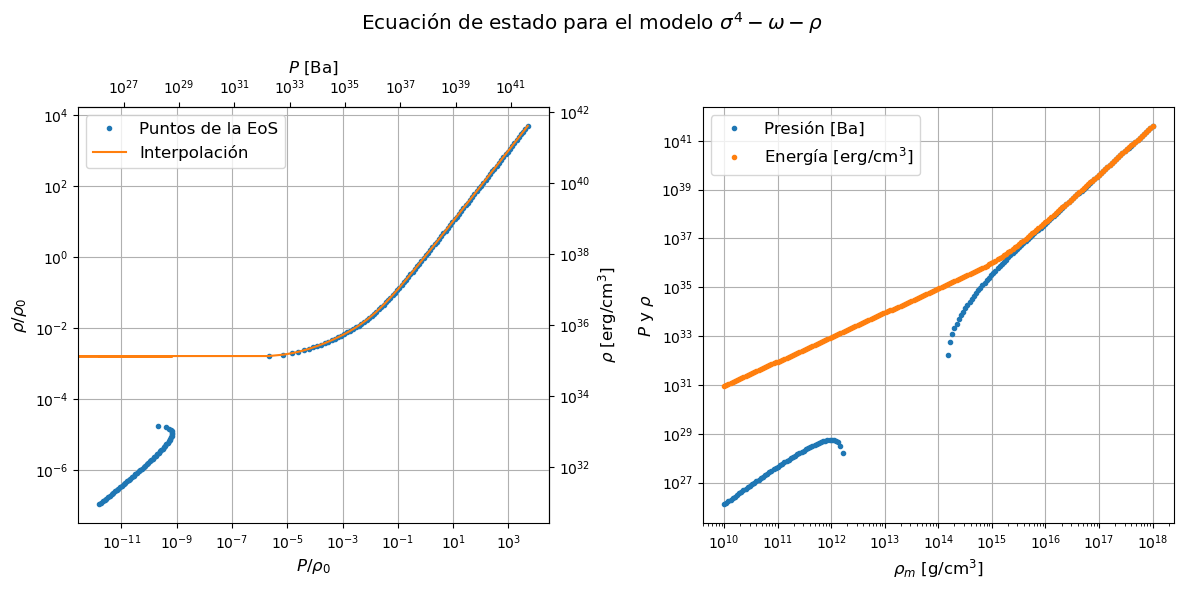

In [14]:
isoEoS.plot_EoS(rho_P, presiones, energias, n_sirve, titulo=r'Ecuación de estado para el modelo $\sigma^4-\omega-\rho$')

### Observables $\frac{B}{A}$, $n_{sat}$, $K_{sat}$ y $a_{sym}$

La masa efectiva en saturación es: 0.758 m_nuc
Densidad de saturación n_saturacion = 0.132 1/fm^3 ( 2.216e+14 g/cm^3 ) y energia de enlace por nucleon en saturación = -15.037 MeV y densidad de energia en saturación = 122.333 MeV/fm^3
Presion en la densidad de saturación: 3.361099516951297e+32 Pa


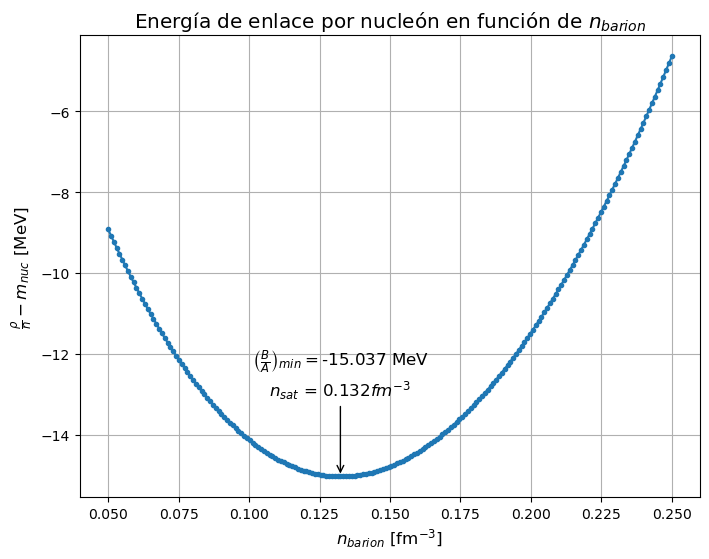

In [15]:
# Graficamos la energia de enlace por nucleon vs la densidad de bariones
# n_prove = np.logspace(-3, -0.5, 200) # Densidades de bariones en fm^-3
n_prove = np.linspace(5e-2, 0.25, 200) # Densidades de bariones en fm^-3
saturacion = isoEoS.plot_saturacion(n_prove, params)

In [10]:
# Calculamos el modulo de compresion y el coeficiente de energía de simetría
K = isoEoS.modulo_compresion(saturacion[0], params)
print(f'Modulo de compresion: {K:.4f} MeV')

a_sym = isoEoS.coeficiente_simetria(saturacion[0], params)
print(f'Coeficiente de simetria: {a_sym:.4f} MeV')

Modulo de compresion: -1203.5213 MeV
Coeficiente de simetria: 22.2128 MeV
